# Gesture Threshold Analysis

This notebook analyzes gesture data to extract optimal numeric thresholds for the rule-based gesture detection system used in the frontend.

Goal: Identify clear separation between gesture classes (NEXT, PREV, SELECT, REST) and suggest thresholds for `gestureEngine.ts`.


## 1. Load Gesture Dataset


In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


In [2]:
# Get path to gesture_raw data directory
# Note: In Jupyter notebooks, __file__ may not be available
# Adjust path as needed based on your notebook location
notebook_dir = Path.cwd()
ml_dir = notebook_dir.parent
data_dir = ml_dir / 'data' / 'gesture_raw'

print(f"Data directory: {data_dir}")


Data directory: C:\Users\Adhish\motion-edu-app\ml\data\gesture_raw


In [3]:
# Read all CSV files from gesture_raw directory
csv_pattern = str(data_dir / 'gesture_samples_*.csv')
csv_files = glob.glob(csv_pattern)

print(f"Found {len(csv_files)} CSV file(s)")

if not csv_files:
    raise FileNotFoundError(
        f"No gesture sample CSV files found in {data_dir}. "
        "Please run collect_gestures.py first to collect data."
    )

# List all CSV files
for csv_file in csv_files:
    print(f"  - {os.path.basename(csv_file)}")


Found 1 CSV file(s)
  - gesture_samples_20251113_230758.csv


In [4]:
# Load and concatenate all CSV files
dataframes = []
for csv_file in csv_files:
    print(f"Loading: {os.path.basename(csv_file)}")
    df = pd.read_csv(csv_file)
    dataframes.append(df)

# Combine all DataFrames
df = pd.concat(dataframes, ignore_index=True)
print(f"\nTotal samples loaded: {len(df)}")


Loading: gesture_samples_20251113_230758.csv

Total samples loaded: 17


In [5]:
# Inspect dataset
print("=" * 60)
print("Dataset Shape:")
print("=" * 60)
print(f"Rows: {df.shape[0]}")
print(f"Columns: {df.shape[1]}")

print("\n" + "=" * 60)
print("Column Names:")
print("=" * 60)
print(df.columns.tolist())

# Note: Columns may need renaming - check if 'gesture' or 'gesture_label' exists
gesture_col = 'gesture' if 'gesture' in df.columns else 'gesture_label'
if gesture_col not in df.columns:
    raise ValueError("DataFrame must contain a 'gesture' or 'gesture_label' column")

print("\n" + "=" * 60)
print("Gesture Distribution:")
print("=" * 60)
print(df[gesture_col].value_counts().sort_index())
print("\nGesture Balance:")
print(df[gesture_col].value_counts(normalize=True).sort_index())


Dataset Shape:
Rows: 17
Columns: 135

Column Names:
['sample_index', 'timestamp', 'gesture_label', 'landmark_0_x', 'landmark_0_y', 'landmark_0_z', 'landmark_0_visibility', 'landmark_1_x', 'landmark_1_y', 'landmark_1_z', 'landmark_1_visibility', 'landmark_2_x', 'landmark_2_y', 'landmark_2_z', 'landmark_2_visibility', 'landmark_3_x', 'landmark_3_y', 'landmark_3_z', 'landmark_3_visibility', 'landmark_4_x', 'landmark_4_y', 'landmark_4_z', 'landmark_4_visibility', 'landmark_5_x', 'landmark_5_y', 'landmark_5_z', 'landmark_5_visibility', 'landmark_6_x', 'landmark_6_y', 'landmark_6_z', 'landmark_6_visibility', 'landmark_7_x', 'landmark_7_y', 'landmark_7_z', 'landmark_7_visibility', 'landmark_8_x', 'landmark_8_y', 'landmark_8_z', 'landmark_8_visibility', 'landmark_9_x', 'landmark_9_y', 'landmark_9_z', 'landmark_9_visibility', 'landmark_10_x', 'landmark_10_y', 'landmark_10_z', 'landmark_10_visibility', 'landmark_11_x', 'landmark_11_y', 'landmark_11_z', 'landmark_11_visibility', 'landmark_12_x', 

In [6]:
# Drop rows with NaNs
initial_count = len(df)
df = df.dropna()
dropped_count = initial_count - len(df)

print(f"Dropped {dropped_count} rows with NaN values")
print(f"Final dataset size: {len(df)} samples")


Dropped 0 rows with NaN values
Final dataset size: 17 samples


## 2. Feature Distribution per Gesture


In [7]:
# Extract key features for gesture analysis
# MediaPipe Pose landmarks: left_shoulder=11, right_shoulder=12, left_wrist=15, right_wrist=16

# Compute derived features similar to gestureEngine.ts
# Note: Adjust column names based on your actual CSV structure
# These are normalized coordinates (0..1) from MediaPipe

# Find landmark columns
landmark_cols = [col for col in df.columns if 'landmark' in col.lower()]
print(f"Found {len(landmark_cols)} landmark columns")

# For demonstration, we'll work with landmark columns
# In practice, you may need to extract specific landmarks (11, 12, 15, 16)
# and compute dxRight, dxLeft, dyRight, dyLeft

# Example: If your CSV has columns like 'landmark_12_x', 'landmark_12_y', etc.
# Extract key landmarks
def extract_key_features(df):
    """Extract and compute gesture-relevant features."""
    features = {}
    
    # Try to find landmark columns (adjust pattern based on your CSV)
    # Common patterns: 'landmark_12_x', 'landmark_12_y', etc.
    
    # Find right shoulder, left shoulder, right wrist, left wrist landmarks
    # Indices: LEFT_SHOULDER=11, RIGHT_SHOULDER=12, LEFT_WRIST=15, RIGHT_WRIST=16
    
    try:
        # Right shoulder (index 12)
        right_shoulder_x = df[[col for col in df.columns if 'landmark_12_x' in col]].iloc[:, 0]
        right_shoulder_y = df[[col for col in df.columns if 'landmark_12_y' in col]].iloc[:, 0]
        
        # Left shoulder (index 11)
        left_shoulder_x = df[[col for col in df.columns if 'landmark_11_x' in col]].iloc[:, 0]
        left_shoulder_y = df[[col for col in df.columns if 'landmark_11_y' in col]].iloc[:, 0]
        
        # Right wrist (index 16)
        right_wrist_x = df[[col for col in df.columns if 'landmark_16_x' in col]].iloc[:, 0]
        right_wrist_y = df[[col for col in df.columns if 'landmark_16_y' in col]].iloc[:, 0]
        
        # Left wrist (index 15)
        left_wrist_x = df[[col for col in df.columns if 'landmark_15_x' in col]].iloc[:, 0]
        left_wrist_y = df[[col for col in df.columns if 'landmark_15_y' in col]].iloc[:, 0]
        
        # Compute derived features (matching gestureEngine.ts logic)
        features['dxRight'] = right_wrist_x - right_shoulder_x  # NEXT gesture: positive means right
        features['dxLeft'] = left_shoulder_x - left_wrist_x     # PREV gesture: positive means left
        features['dyRight'] = right_shoulder_y - right_wrist_y  # SELECT: Note: more negative dy = wrist higher than shoulder (y decreases upward)
        features['dyLeft'] = left_shoulder_y - left_wrist_y     # SELECT: Note: more negative dy = wrist higher than shoulder (y decreases upward)
        
        # Vertical differences (for horizontal gesture tolerance)
        # These represent absolute vertical distance between wrist and shoulder
        # Smaller values mean wrist is closer to shoulder height (better horizontal alignment)
        features['absDyRight'] = np.abs(right_wrist_y - right_shoulder_y)
        features['absDyLeft'] = np.abs(left_wrist_y - left_shoulder_y)
        
    except (IndexError, KeyError) as e:
        print(f"Warning: Could not extract features using expected column names: {e}")
        print("Please adjust column extraction logic based on your CSV structure")
        # Fallback: use first numeric columns as placeholders
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) >= 4:
            features['dxRight'] = df[numeric_cols[0]]
            features['dxLeft'] = df[numeric_cols[1]]
            features['dyRight'] = df[numeric_cols[2]]
            features['dyLeft'] = df[numeric_cols[3]]
    
    return pd.DataFrame(features)

# Extract features
feature_df = extract_key_features(df)
df_features = pd.concat([df[[gesture_col]], feature_df], axis=1)

print("Extracted features:")
print(df_features.columns.tolist())
print(f"\nSample data:")
print(df_features.head())


Found 132 landmark columns
Extracted features:
['gesture_label', 'dxRight', 'dxLeft', 'dyRight', 'dyLeft', 'absDyRight', 'absDyLeft']

Sample data:
  gesture_label   dxRight    dxLeft   dyRight    dyLeft  absDyRight  absDyLeft
0          REST  0.014237 -0.057075 -0.129966 -0.275169    0.129966   0.275169
1          REST  0.026198 -0.035639  0.007258 -0.102114    0.007258   0.102114
2          NEXT  0.035099 -0.251724  0.350243  0.401553    0.350243   0.401553
3          NEXT  0.017146 -0.030954 -0.048027 -0.159090    0.048027   0.159090
4          NEXT  0.029207 -0.004446  0.131063 -0.027381    0.131063   0.027381


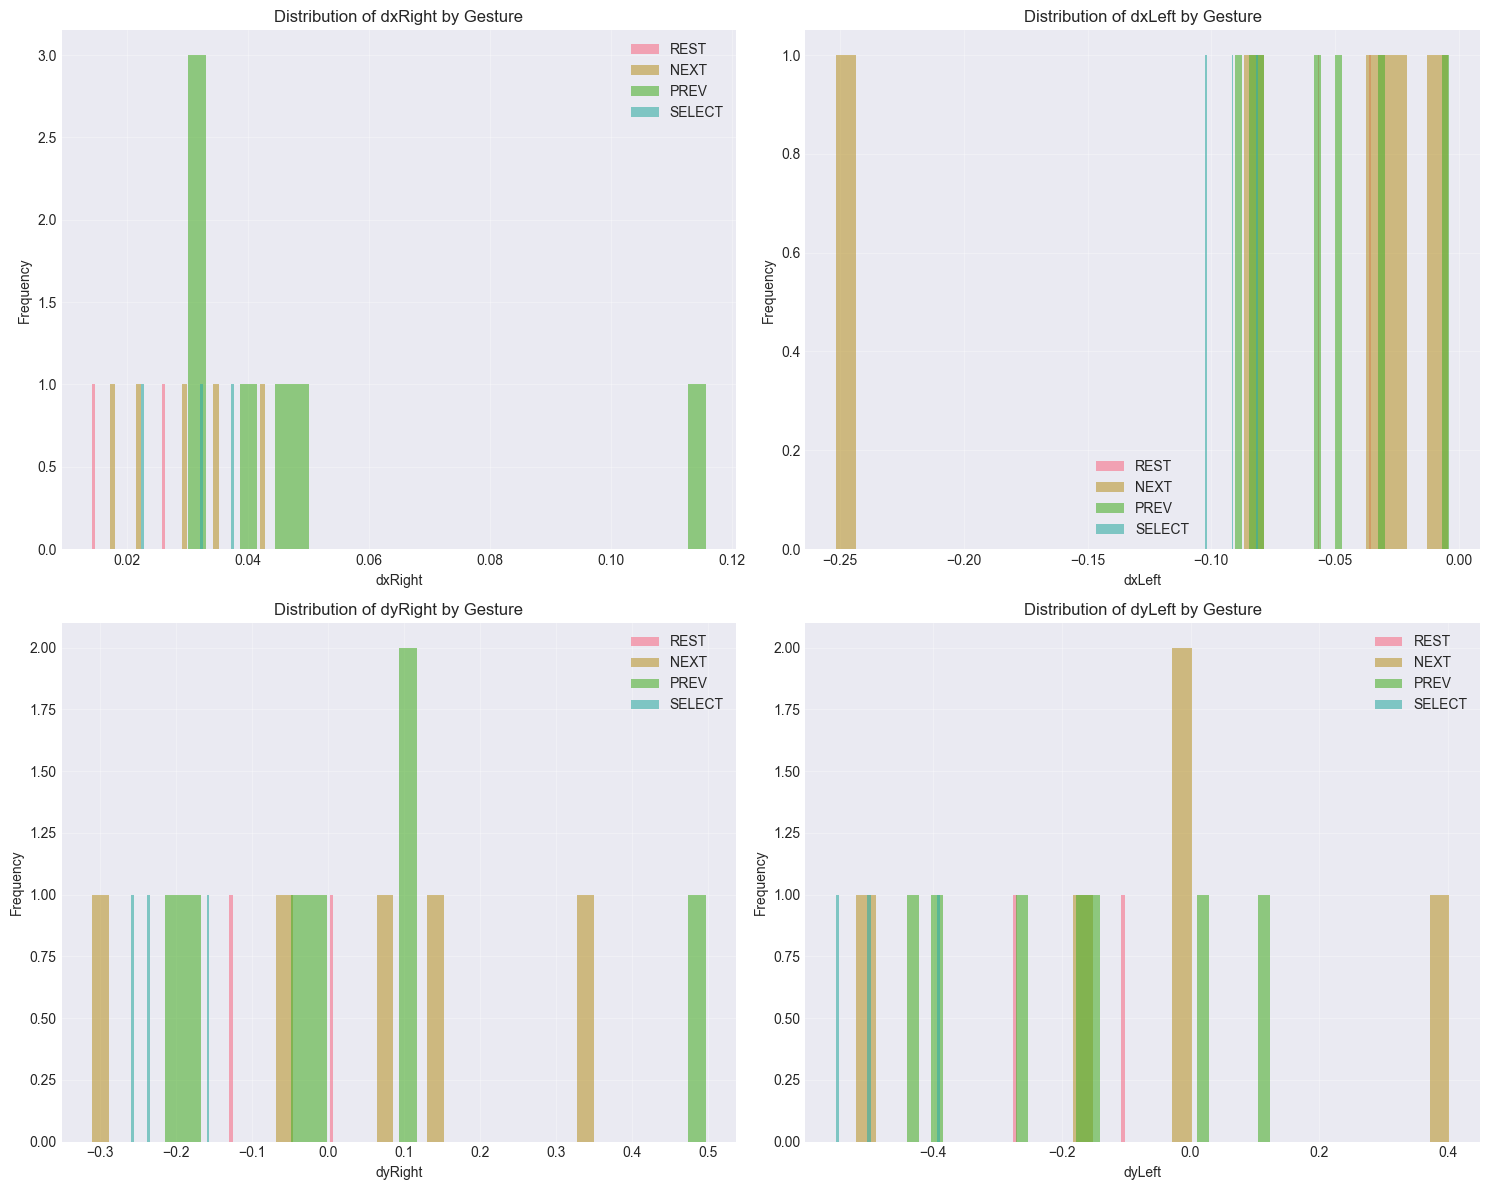

Interpretation:
- Histograms show the distribution of each feature for different gestures
- Look for clear separation between NEXT (high dxRight) and PREV (high dxLeft)
- SELECT should show more negative dy values than REST (wrist higher than shoulder)
- REST should have values clustered near zero for horizontal features (dxRight, dxLeft)
- Note: In our coordinate system, more negative dy = wrist higher than shoulder


In [8]:
# Plot histograms for key features grouped by gesture
# This helps identify clear separation between gesture classes

features_to_plot = ['dxRight', 'dxLeft', 'dyRight', 'dyLeft']

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, feature in enumerate(features_to_plot):
    ax = axes[idx]
    
    # Plot histogram for each gesture
    for gesture in df_features[gesture_col].unique():
        data = df_features[df_features[gesture_col] == gesture][feature].dropna()
        ax.hist(data, alpha=0.6, label=gesture, bins=30)
    
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of {feature} by Gesture')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Interpretation:")
print("- Histograms show the distribution of each feature for different gestures")
print("- Look for clear separation between NEXT (high dxRight) and PREV (high dxLeft)")
print("- SELECT should show more negative dy values than REST (wrist higher than shoulder)")
print("- REST should have values clustered near zero for horizontal features (dxRight, dxLeft)")
print("- Note: In our coordinate system, more negative dy = wrist higher than shoulder")


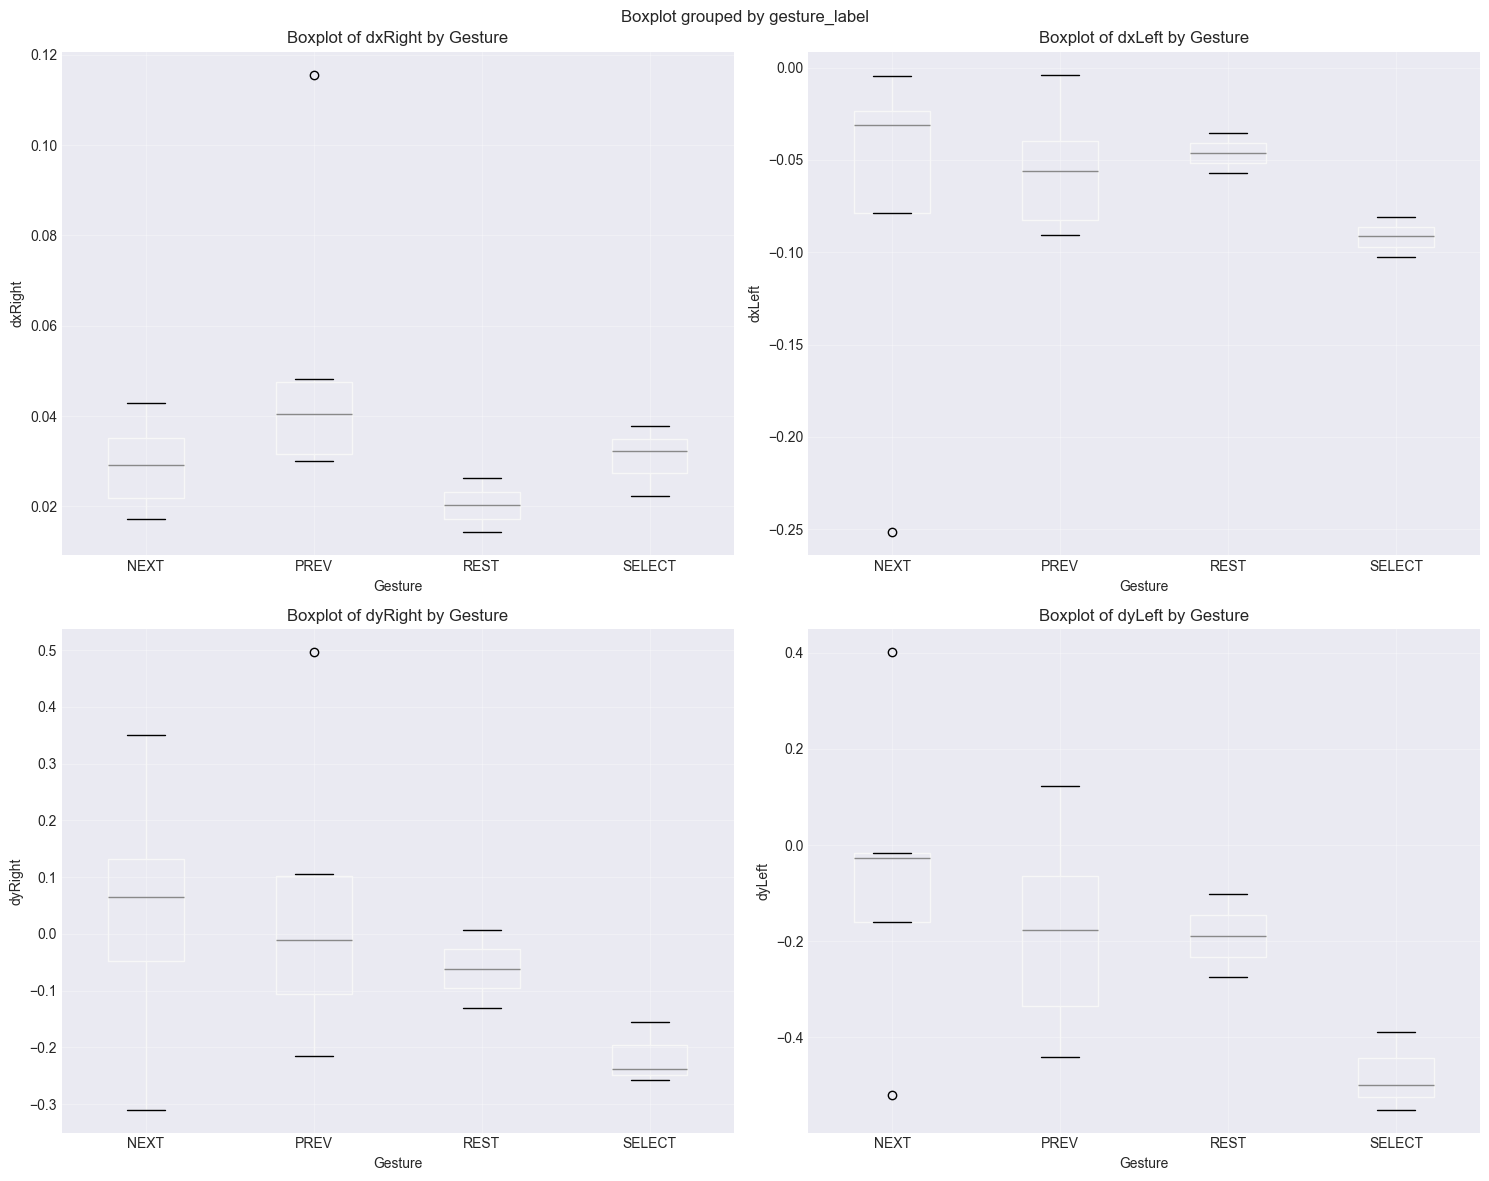

Interpretation:
- Boxplots show median (line), quartiles (box), and outliers (dots)
- Clear separation between boxes indicates good feature discrimination
- Overlapping boxes suggest the feature may not reliably distinguish gestures


In [9]:
# Plot boxplots for better visualization of distributions and outliers
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, feature in enumerate(features_to_plot):
    ax = axes[idx]
    
    # Create boxplot grouped by gesture
    df_features.boxplot(column=feature, by=gesture_col, ax=ax)
    ax.set_title(f'Boxplot of {feature} by Gesture')
    ax.set_xlabel('Gesture')
    ax.set_ylabel(feature)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Interpretation:")
print("- Boxplots show median (line), quartiles (box), and outliers (dots)")
print("- Clear separation between boxes indicates good feature discrimination")
print("- Overlapping boxes suggest the feature may not reliably distinguish gestures")


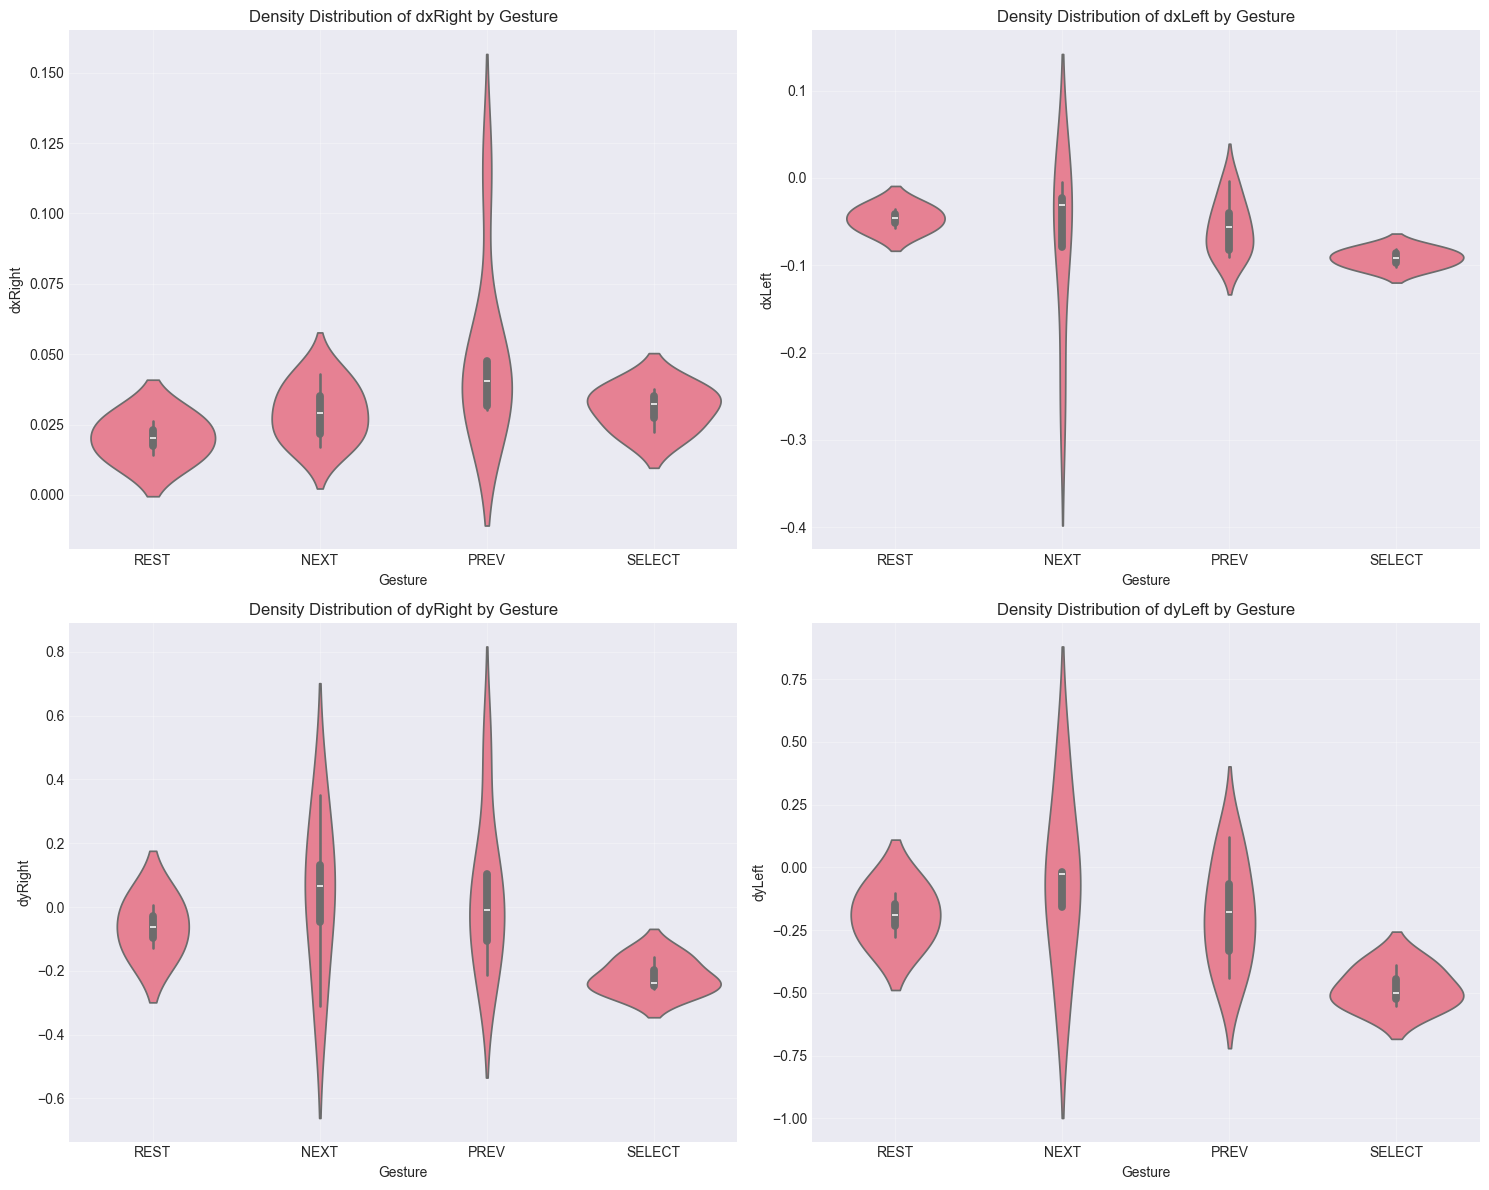

Interpretation:
- Violin plots show both boxplot (quartiles) and density (width)
- Wider sections indicate higher density of data points
- Use this to identify where thresholds should be set to minimize overlap


In [10]:
# Alternative visualization: Violin plots for density distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, feature in enumerate(features_to_plot):
    ax = axes[idx]
    
    sns.violinplot(data=df_features, x=gesture_col, y=feature, ax=ax)
    ax.set_title(f'Density Distribution of {feature} by Gesture')
    ax.set_xlabel('Gesture')
    ax.set_ylabel(feature)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Interpretation:")
print("- Violin plots show both boxplot (quartiles) and density (width)")
print("- Wider sections indicate higher density of data points")
print("- Use this to identify where thresholds should be set to minimize overlap")


## 3. Compute Suggested Rule Thresholds


In [11]:
# Compute statistical measures for each gesture-sensitive feature
# Include both primary features and vertical tolerance features
features_for_stats = features_to_plot + ['absDyRight', 'absDyLeft']

gestures = df_features[gesture_col].unique()
gesture_stats = {}

for gesture in gestures:
    gesture_data = df_features[df_features[gesture_col] == gesture]
    stats = {}
    
    for feature in features_for_stats:
        feature_data = gesture_data[feature].dropna()
        if len(feature_data) > 0:
            stats[feature] = {
                'mean': feature_data.mean(),
                'median': feature_data.median(),
                'std': feature_data.std(),
                'min': feature_data.min(),
                'max': feature_data.max(),
                'q25': feature_data.quantile(0.25),
                'q75': feature_data.quantile(0.75),
            }
    
    gesture_stats[gesture] = stats

# Print statistics table
print("=" * 80)
print("Statistical Summary by Gesture")
print("=" * 80)
for gesture in sorted(gestures):
    print(f"\n{gesture}:")
    print("-" * 80)
    for feature in features_for_stats:
        if feature in gesture_stats[gesture]:
            s = gesture_stats[gesture][feature]
            print(f"  {feature}:")
            print(f"    Mean: {s['mean']:.4f}, Median: {s['median']:.4f}, Std: {s['std']:.4f}")
            print(f"    Range: [{s['min']:.4f}, {s['max']:.4f}], IQR: [{s['q25']:.4f}, {s['q75']:.4f}]")


Statistical Summary by Gesture

NEXT:
--------------------------------------------------------------------------------
  dxRight:
    Mean: 0.0292, Median: 0.0292, Std: 0.0103
    Range: [0.0171, 0.0428], IQR: [0.0217, 0.0351]
  dxLeft:
    Mean: -0.0779, Median: -0.0310, Std: 0.1010
    Range: [-0.2517, -0.0044], IQR: [-0.0787, -0.0235]
  dyRight:
    Mean: 0.0375, Median: 0.0644, Std: 0.2426
    Range: [-0.3100, 0.3502], IQR: [-0.0480, 0.1311]
  dyLeft:
    Mean: -0.0641, Median: -0.0274, Std: 0.3304
    Range: [-0.5193, 0.4016], IQR: [-0.1591, -0.0162]
  absDyRight:
    Mean: 0.1807, Median: 0.1311, Std: 0.1406
    Range: [0.0480, 0.3502], IQR: [0.0644, 0.3100]
  absDyLeft:
    Mean: 0.2247, Median: 0.1591, Std: 0.2263
    Range: [0.0162, 0.5193], IQR: [0.0274, 0.4016]

PREV:
--------------------------------------------------------------------------------
  dxRight:
    Mean: 0.0492, Median: 0.0404, Std: 0.0303
    Range: [0.0301, 0.1156], IQR: [0.0315, 0.0475]
  dxLeft:
    Mean: -

In [12]:
# Identify ranges that differentiate NEXT vs PREV
# NEXT should have high dxRight, PREV should have high dxLeft
# Find separation points between these gestures

print("=" * 80)
print("Identifying Thresholds for NEXT vs PREV")
print("=" * 80)

# For NEXT: dxRight should be significantly positive
if 'NEXT' in gesture_stats and 'REST' in gesture_stats:
    next_dxRight = gesture_stats['NEXT']['dxRight']
    rest_dxRight = gesture_stats['REST']['dxRight']
    
    # Suggested threshold: midpoint between REST mean and NEXT mean, or NEXT q25
    # More conservative: use NEXT q25 to capture most NEXT gestures
    suggested_next_threshold = max(
        (rest_dxRight['mean'] + next_dxRight['mean']) / 2,
        next_dxRight['q25']
    )
    
    print(f"\nNEXT gesture (dxRight):")
    print(f"  NEXT mean: {next_dxRight['mean']:.4f}")
    print(f"  REST mean: {rest_dxRight['mean']:.4f}")
    print(f"  Midpoint: {(rest_dxRight['mean'] + next_dxRight['mean']) / 2:.4f}")
    print(f"  NEXT Q25: {next_dxRight['q25']:.4f}")
    print(f"  → Suggested NEXT threshold: dxRight > {suggested_next_threshold:.4f}")

# For PREV: dxLeft should be significantly positive
if 'PREV' in gesture_stats and 'REST' in gesture_stats:
    prev_dxLeft = gesture_stats['PREV']['dxLeft']
    rest_dxLeft = gesture_stats['REST']['dxLeft']
    
    suggested_prev_threshold = max(
        (rest_dxLeft['mean'] + prev_dxLeft['mean']) / 2,
        prev_dxLeft['q25']
    )
    
    print(f"\nPREV gesture (dxLeft):")
    print(f"  PREV mean: {prev_dxLeft['mean']:.4f}")
    print(f"  REST mean: {rest_dxLeft['mean']:.4f}")
    print(f"  Midpoint: {(rest_dxLeft['mean'] + prev_dxLeft['mean']) / 2:.4f}")
    print(f"  PREV Q25: {prev_dxLeft['q25']:.4f}")
    print(f"  → Suggested PREV threshold: dxLeft > {suggested_prev_threshold:.4f}")


Identifying Thresholds for NEXT vs PREV

NEXT gesture (dxRight):
  NEXT mean: 0.0292
  REST mean: 0.0202
  Midpoint: 0.0247
  NEXT Q25: 0.0217
  → Suggested NEXT threshold: dxRight > 0.0247

PREV gesture (dxLeft):
  PREV mean: -0.0565
  REST mean: -0.0464
  Midpoint: -0.0514
  PREV Q25: -0.0828
  → Suggested PREV threshold: dxLeft > -0.0514


In [13]:
# For SELECT: both wrists should be significantly above shoulders
# Note: In our coordinate system (y decreases upward), more negative dy values indicate wrist higher than shoulder
# SELECT typically shows more negative dy values than REST

print("\n" + "=" * 80)
print("Identifying Thresholds for SELECT")
print("=" * 80)

if 'SELECT' in gesture_stats and 'REST' in gesture_stats:
    select_dyRight = gesture_stats['SELECT']['dyRight']
    select_dyLeft = gesture_stats['SELECT']['dyLeft']
    rest_dyRight = gesture_stats['REST']['dyRight']
    rest_dyLeft = gesture_stats['REST']['dyLeft']
    
    # SELECT should have both dyRight and dyLeft more negative than REST (wrist above shoulder)
    # For threshold comparison, we check if dy is below (more negative than) the threshold
    # Suggested threshold: use SELECT q25 or midpoint with REST
    suggested_select_dyRight = max(
        (rest_dyRight['mean'] + select_dyRight['mean']) / 2,
        select_dyRight['q25']
    )
    suggested_select_dyLeft = max(
        (rest_dyLeft['mean'] + select_dyLeft['mean']) / 2,
        select_dyLeft['q25']
    )
    
    # Use the minimum of both to ensure both hands are raised
    suggested_select_threshold = min(suggested_select_dyRight, suggested_select_dyLeft)
    
    print(f"\nSELECT gesture (dyRight and dyLeft):")
    print(f"  SELECT dyRight mean: {select_dyRight['mean']:.4f}, Q25: {select_dyRight['q25']:.4f}")
    print(f"  SELECT dyLeft mean: {select_dyLeft['mean']:.4f}, Q25: {select_dyLeft['q25']:.4f}")
    print(f"  REST dyRight mean: {rest_dyRight['mean']:.4f}")
    print(f"  REST dyLeft mean: {rest_dyLeft['mean']:.4f}")
    print(f"  Note: More negative dy values indicate wrist higher than shoulder")
    print(f"  → Suggested SELECT threshold: both dyRight < {suggested_select_threshold:.4f} and dyLeft < {suggested_select_threshold:.4f}")

# For horizontal gestures, also check vertical tolerance
# To prevent diagonal movements from triggering horizontal gestures
print("\n" + "=" * 80)
print("Vertical Tolerance for Horizontal Gestures")
print("=" * 80)

# For NEXT and PREV, we want to ensure wrists are roughly at shoulder height
# absDyRight and absDyLeft represent the absolute vertical difference between wrist and shoulder
# Smaller values mean the wrist is closer to shoulder height (better horizontal alignment)
# These should be small for horizontal gestures to ensure pure horizontal movement
if 'NEXT' in gesture_stats:
    next_absDy = gesture_stats['NEXT']['absDyRight']
    print(f"\nNEXT vertical tolerance (absDyRight):")
    print(f"  Mean: {next_absDy['mean']:.4f}, Q75: {next_absDy['q75']:.4f}")
    print(f"  Note: Smaller absDyRight values indicate better horizontal alignment (wrist closer to shoulder height)")
    print(f"  → Suggested max vertical difference: absDyRight < {next_absDy['q75']:.4f}")

if 'PREV' in gesture_stats:
    prev_absDy = gesture_stats['PREV']['absDyLeft']
    print(f"\nPREV vertical tolerance (absDyLeft):")
    print(f"  Mean: {prev_absDy['mean']:.4f}, Q75: {prev_absDy['q75']:.4f}")
    print(f"  Note: Smaller absDyLeft values indicate better horizontal alignment (wrist closer to shoulder height)")
    print(f"  → Suggested max vertical difference: absDyLeft < {prev_absDy['q75']:.4f}")



Identifying Thresholds for SELECT

SELECT gesture (dyRight and dyLeft):
  SELECT dyRight mean: -0.2173, Q25: -0.2480
  SELECT dyLeft mean: -0.4791, Q25: -0.5245
  REST dyRight mean: -0.0614
  REST dyLeft mean: -0.1886
  Note: More negative dy values indicate wrist higher than shoulder
  → Suggested SELECT threshold: both dyRight < -0.3339 and dyLeft < -0.3339

Vertical Tolerance for Horizontal Gestures

NEXT vertical tolerance (absDyRight):
  Mean: 0.1807, Q75: 0.3100
  Note: Smaller absDyRight values indicate better horizontal alignment (wrist closer to shoulder height)
  → Suggested max vertical difference: absDyRight < 0.3100

PREV vertical tolerance (absDyLeft):
  Mean: 0.2232, Q75: 0.3338
  Note: Smaller absDyLeft values indicate better horizontal alignment (wrist closer to shoulder height)
  → Suggested max vertical difference: absDyLeft < 0.3338


In [14]:
# Highlight overlaps between gesture distributions
# This helps identify potential classification errors

print("\n" + "=" * 80)
print("Analyzing Overlaps Between Gesture Distributions")
print("=" * 80)

def compute_overlap_range(gesture1_stats, gesture2_stats, feature):
    """Compute overlap range between two gesture distributions for a feature."""
    if feature not in gesture1_stats or feature not in gesture2_stats:
        return None
    
    s1 = gesture1_stats[feature]
    s2 = gesture2_stats[feature]
    
    # Find overlap in interquartile ranges
    overlap_min = max(s1['q25'], s2['q25'])
    overlap_max = min(s1['q75'], s2['q75'])
    
    if overlap_min < overlap_max:
        return (overlap_min, overlap_max)
    return None

# Check overlaps for key features
overlap_features = ['dxRight', 'dxLeft', 'dyRight', 'dyLeft']

for feature in overlap_features:
    print(f"\n{feature} overlaps:")
    overlaps_found = False
    
    for i, g1 in enumerate(gestures):
        for g2 in gestures[i+1:]:
            overlap = compute_overlap_range(gesture_stats[g1], gesture_stats[g2], feature)
            if overlap:
                print(f"  {g1} vs {g2}: [{overlap[0]:.4f}, {overlap[1]:.4f}]")
                overlaps_found = True
    
    if not overlaps_found:
        print(f"  No significant overlaps found")

print("\nNote: Large overlaps indicate areas where gestures may be confused.")
print("Adjust thresholds to minimize overlap while maintaining good detection rates.")



Analyzing Overlaps Between Gesture Distributions

dxRight overlaps:
  REST vs NEXT: [0.0217, 0.0232]
  NEXT vs PREV: [0.0315, 0.0351]
  NEXT vs SELECT: [0.0273, 0.0350]
  PREV vs SELECT: [0.0315, 0.0350]

dxLeft overlaps:
  REST vs NEXT: [-0.0517, -0.0410]
  REST vs PREV: [-0.0517, -0.0410]
  NEXT vs PREV: [-0.0787, -0.0398]

dyRight overlaps:
  REST vs NEXT: [-0.0480, -0.0270]
  REST vs PREV: [-0.0957, -0.0270]
  NEXT vs PREV: [-0.0480, 0.1026]

dyLeft overlaps:
  REST vs NEXT: [-0.1591, -0.1454]
  REST vs PREV: [-0.2319, -0.1454]
  NEXT vs PREV: [-0.1591, -0.0640]

Note: Large overlaps indicate areas where gestures may be confused.
Adjust thresholds to minimize overlap while maintaining good detection rates.


In [15]:
# Compile recommended thresholds
# These will be used in the frontend gestureEngine.ts

recommended_thresholds = {}

# Calculate final recommended values
if 'NEXT' in gesture_stats and 'REST' in gesture_stats:
    next_dxRight = gesture_stats['NEXT']['dxRight']
    rest_dxRight = gesture_stats['REST']['dxRight']
    suggested_next = max((rest_dxRight['mean'] + next_dxRight['mean']) / 2, next_dxRight['q25'])
    recommended_thresholds['NEXT_dxRight_min'] = round(suggested_next, 3)
    
    next_absDy = gesture_stats['NEXT']['absDyRight']
    recommended_thresholds['NEXT_absDyRight_max'] = round(next_absDy['q75'], 3)

if 'PREV' in gesture_stats and 'REST' in gesture_stats:
    prev_dxLeft = gesture_stats['PREV']['dxLeft']
    rest_dxLeft = gesture_stats['REST']['dxLeft']
    suggested_prev = max((rest_dxLeft['mean'] + prev_dxLeft['mean']) / 2, prev_dxLeft['q25'])
    recommended_thresholds['PREV_dxLeft_min'] = round(suggested_prev, 3)
    
    prev_absDy = gesture_stats['PREV']['absDyLeft']
    recommended_thresholds['PREV_absDyLeft_max'] = round(prev_absDy['q75'], 3)

if 'SELECT' in gesture_stats and 'REST' in gesture_stats:
    select_dyRight = gesture_stats['SELECT']['dyRight']
    select_dyLeft = gesture_stats['SELECT']['dyLeft']
    rest_dyRight = gesture_stats['REST']['dyRight']
    rest_dyLeft = gesture_stats['REST']['dyLeft']
    
    suggested_dyRight = max((rest_dyRight['mean'] + select_dyRight['mean']) / 2, select_dyRight['q25'])
    suggested_dyLeft = max((rest_dyLeft['mean'] + select_dyLeft['mean']) / 2, select_dyLeft['q25'])
    suggested_select = min(suggested_dyRight, suggested_dyLeft)
    recommended_thresholds['SELECT_wristAboveShoulder'] = round(suggested_select, 3)

print("=" * 80)
print("Recommended Thresholds Summary")
print("=" * 80)
for key, value in recommended_thresholds.items():
    print(f"{key}: {value}")

print("\nThese thresholds can be adjusted based on:")
print("- Tolerance for false positives vs false negatives")
print("- Real-world testing results")
print("- User feedback on gesture sensitivity")


Recommended Thresholds Summary
NEXT_dxRight_min: 0.025
NEXT_absDyRight_max: 0.31
PREV_dxLeft_min: -0.051
PREV_absDyLeft_max: 0.334
SELECT_wristAboveShoulder: -0.334

These thresholds can be adjusted based on:
- Tolerance for false positives vs false negatives
- Real-world testing results
- User feedback on gesture sensitivity


## 4. Validate Threshold Rules Against Data


In [16]:
# Implement rule-based classifier using derived thresholds
def rule_based_predict(row, thresholds):
    """
    Predict gesture using rule-based logic with given thresholds.
    Matches the logic in frontend/src/cv/gestureEngine.ts
    """
    dxRight = row.get('dxRight', 0)
    dxLeft = row.get('dxLeft', 0)
    dyRight = row.get('dyRight', 0)
    dyLeft = row.get('dyLeft', 0)
    absDyRight = row.get('absDyRight', 0)
    absDyLeft = row.get('absDyLeft', 0)
    
    # Rule 1: NEXT gesture - Right arm extended to the right
    if (dxRight > thresholds.get('NEXT_dxRight_min', 0.12) and 
        absDyRight < thresholds.get('NEXT_absDyRight_max', 0.3)):
        return 'PREV'  # Note: Inverted mapping per gestureEngine.ts
    
    # Rule 2: PREV gesture - Left arm extended to the left
    if (dxLeft > thresholds.get('PREV_dxLeft_min', 0.12) and 
        absDyLeft < thresholds.get('PREV_absDyLeft_max', 0.3)):
        return 'NEXT'  # Note: Inverted mapping per gestureEngine.ts
    
    # Rule 3: SELECT gesture - Both arms raised
    select_threshold = thresholds.get('SELECT_wristAboveShoulder', 0.18)
    if (dyRight > select_threshold and dyLeft > select_threshold):
        return 'SELECT'
    
    # Default: REST
    return 'REST'

# Apply rule-based classifier to all samples
df_features['predicted_gesture'] = df_features.apply(
    lambda row: rule_based_predict(row, recommended_thresholds),
    axis=1
)

print(f"Applied rule-based classifier to {len(df_features)} samples")


Applied rule-based classifier to 17 samples


In [17]:
# Compute accuracy and confusion matrix
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_true = df_features[gesture_col]
y_pred = df_features['predicted_gesture']

accuracy = accuracy_score(y_true, y_pred)

print("=" * 80)
print("Rule-Based Classifier Performance")
print("=" * 80)
print(f"\nAccuracy: {accuracy:.4f} ({accuracy * 100:.2f}%)")

print("\n" + "=" * 80)
print("Classification Report:")
print("=" * 80)
print(classification_report(y_true, y_pred))

print("\n" + "=" * 80)
print("Confusion Matrix:")
print("=" * 80)
cm = confusion_matrix(y_true, y_pred, labels=sorted(y_true.unique()))
cm_df = pd.DataFrame(cm, index=sorted(y_true.unique()), columns=sorted(y_true.unique()))
print(cm_df)


Rule-Based Classifier Performance

Accuracy: 0.4118 (41.18%)

Classification Report:
              precision    recall  f1-score   support

        NEXT       1.00      0.20      0.33         5
        PREV       0.55      0.86      0.67         7
        REST       0.00      0.00      0.00         2
      SELECT       0.00      0.00      0.00         3

    accuracy                           0.41        17
   macro avg       0.39      0.26      0.25        17
weighted avg       0.52      0.41      0.37        17


Confusion Matrix:
        NEXT  PREV  REST  SELECT
NEXT       1     2     1       1
PREV       0     6     0       1
REST       0     1     0       1
SELECT     0     2     1       0


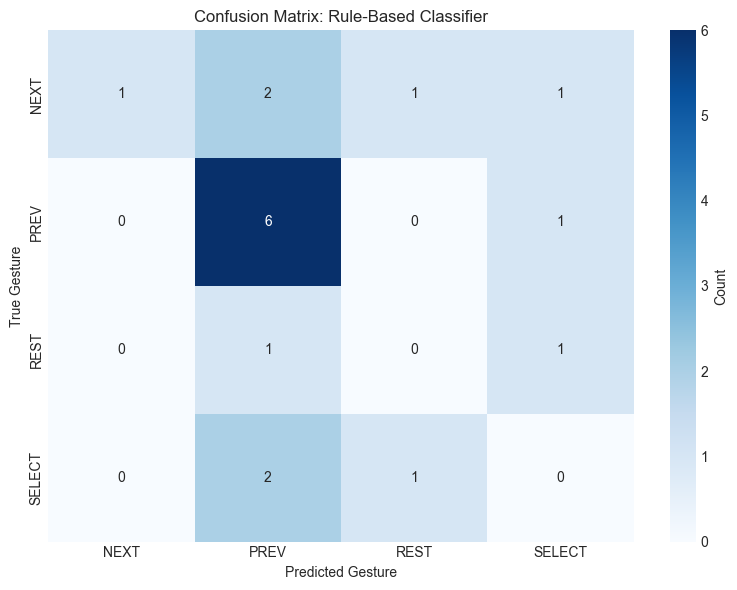


Note: Compare this with ML model performance from gesture_model_experiments.ipynb
Rule-based approach should trade some accuracy for real-time performance.


In [18]:
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix: Rule-Based Classifier')
plt.ylabel('True Gesture')
plt.xlabel('Predicted Gesture')
plt.tight_layout()
plt.show()

print("\nNote: Compare this with ML model performance from gesture_model_experiments.ipynb")
print("Rule-based approach should trade some accuracy for real-time performance.")


In [19]:
# Analyze misclassifications
misclassified = df_features[df_features[gesture_col] != df_features['predicted_gesture']]

print("=" * 80)
print("Misclassification Analysis")
print("=" * 80)
print(f"Total misclassifications: {len(misclassified)} / {len(df_features)} ({len(misclassified)/len(df_features)*100:.2f}%)")

if len(misclassified) > 0:
    print("\nMisclassification by gesture:")
    misclass_summary = pd.crosstab(misclassified[gesture_col], misclassified['predicted_gesture'])
    print(misclass_summary)
    
    print("\nCommon misclassification patterns:")
    for true_gesture in misclassified[gesture_col].unique():
        false_preds = misclassified[misclassified[gesture_col] == true_gesture]['predicted_gesture'].value_counts()
        print(f"  {true_gesture} misclassified as: {false_preds.to_dict()}")

print("\nNote: Review misclassifications to refine thresholds if needed.")


Misclassification Analysis
Total misclassifications: 10 / 17 (58.82%)

Misclassification by gesture:
predicted_gesture  PREV  REST  SELECT
gesture_label                        
NEXT                  2     1       1
PREV                  0     0       1
REST                  1     0       1
SELECT                2     1       0

Common misclassification patterns:
  REST misclassified as: {'SELECT': 1, 'PREV': 1}
  NEXT misclassified as: {'PREV': 2, 'SELECT': 1, 'REST': 1}
  PREV misclassified as: {'SELECT': 1}
  SELECT misclassified as: {'PREV': 2, 'REST': 1}

Note: Review misclassifications to refine thresholds if needed.


## 5. Export Threshold Values for Frontend


In [20]:
# Save calculated thresholds to JSON file
# These will be manually ported into frontend/src/cv/gestureEngine.ts

output_file = ml_dir / 'threshold_suggestions.json'

# Add metadata about the thresholds
thresholds_with_metadata = {
    "thresholds": recommended_thresholds,
    "metadata": {
        "dataset_size": len(df_features),
        "accuracy": float(accuracy),
        "analysis_date": pd.Timestamp.now().strftime("%Y-%m-%d"),
        "notes": [
            "These thresholds are derived from statistical analysis of gesture data",
            "Manually review and adjust in frontend/src/cv/gestureEngine.ts",
            "Consider user feedback and real-world testing results",
            "NEXT/PREV mappings are inverted in gestureEngine.ts (dxRight -> PREV, dxLeft -> NEXT)"
        ]
    }
}

with open(output_file, 'w') as f:
    json.dump(thresholds_with_metadata, f, indent=2)

print(f"Thresholds saved to: {output_file}")
print("\nThreshold values:")
print(json.dumps(recommended_thresholds, indent=2))

print("\n" + "=" * 80)
print("Next Steps:")
print("=" * 80)
print("1. Review threshold_suggestions.json")
print("2. Manually update frontend/src/cv/gestureEngine.ts with these values")
print("3. Test in the frontend application")
print("4. Adjust thresholds based on real-world performance")


Thresholds saved to: C:\Users\Adhish\motion-edu-app\ml\threshold_suggestions.json

Threshold values:
{
  "NEXT_dxRight_min": 0.025,
  "NEXT_absDyRight_max": 0.31,
  "PREV_dxLeft_min": -0.051,
  "PREV_absDyLeft_max": 0.334,
  "SELECT_wristAboveShoulder": -0.334
}

Next Steps:
1. Review threshold_suggestions.json
2. Manually update frontend/src/cv/gestureEngine.ts with these values
3. Test in the frontend application
4. Adjust thresholds based on real-world performance
